# Exploratory Data Analysis (EDA) 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import sklearn
from tqdm import tqdm
import IPython

Total number of Monet images: 300


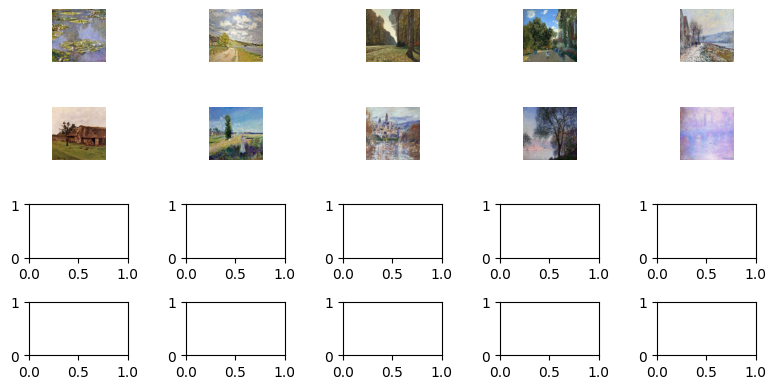

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import glob

monet_paths = glob.glob("../input/gan-getting-started/monet_jpg/*.jpg")

print(f'Total number of Monet images: {len(monet_paths)}')

fig, axes = plt.subplots(4, 5, figsize=(8, 4))

for ax, img_path in zip(axes.flatten(), monet_paths[:10]):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()


### **Extracting Basic Features of Images**

Purpose: To examine basic information such as dimensions, color features, pixel distribution of images.

In [3]:
from PIL import Image
import pandas as pd

image_sizes = []

for img_path in monet_paths:
    img = Image.open(img_path)
    image_sizes.append(img.size)

df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

print(df_sizes.head())

df_sizes.describe()


   Width  Height
0    256     256
1    256     256
2    256     256
3    256     256
4    256     256


,Width,Height
count,300.0,300.0
mean,256.0,256.0
std,0.0,0.0
min,256.0,256.0
25%,256.0,256.0
50%,256.0,256.0
75%,256.0,256.0
max,256.0,256.0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


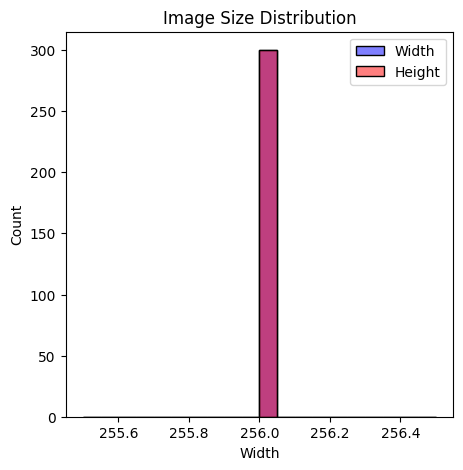

In [4]:
import seaborn as sns

plt.figure(figsize=(5, 5))
sns.histplot(df_sizes['Width'], bins=20, color="blue", label="Width", kde=True)
sns.histplot(df_sizes['Height'], bins=20, color="red", label="Height", kde=True)
plt.legend()
plt.title("Image Size Distribution")
plt.show()


### **Examining Color Distribution**

Purpose: What are the color palettes and tones of Monet paintings? If a fake Monet is to be produced with GAN, the original Monet color distribution must be well understood.

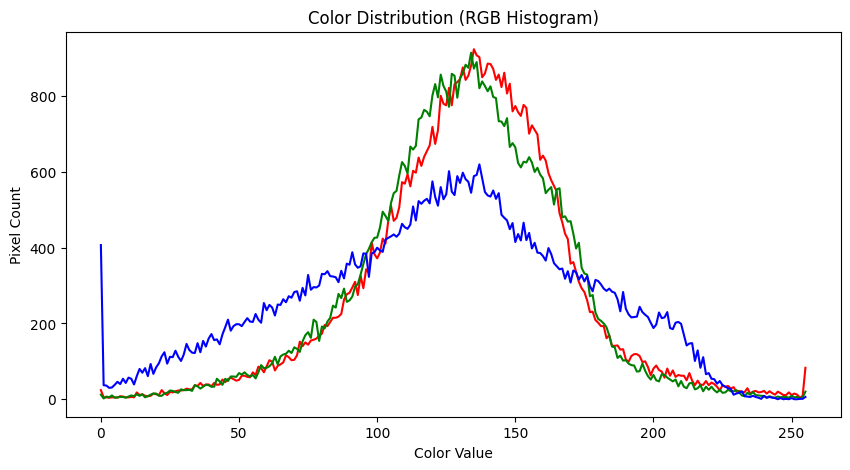

In [5]:
import cv2
import numpy as np

img = cv2.imread(monet_paths[0])  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
color = ('r', 'g', 'b')
for i, col in enumerate(color):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist, color=col)

plt.title("Color Distribution (RGB Histogram)")
plt.xlabel("Color Value")
plt.ylabel("Pixel Count")
plt.show()


### **Understanding the Edges and Structure of Images**

Purpose: To analyze the edge structure and level of detail of Monet's paintings.

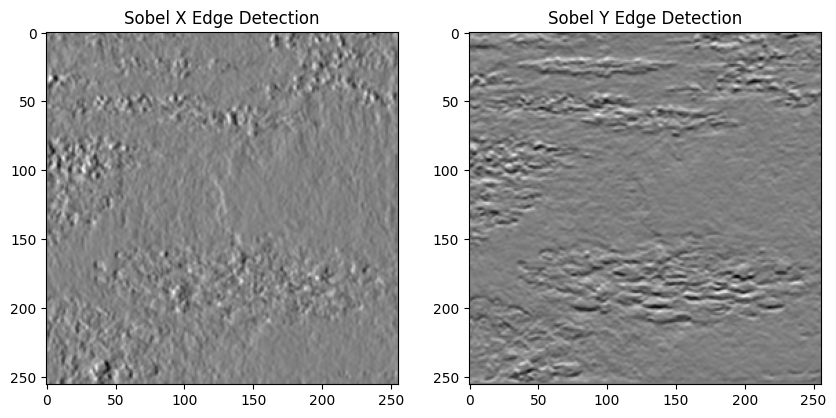

In [6]:
import cv2

img = cv2.imread(monet_paths[0], cv2.IMREAD_GRAYSCALE)

sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sobelx, cmap='gray')
plt.title("Sobel X Edge Detection")

plt.subplot(1, 2, 2)
plt.imshow(sobely, cmap='gray')
plt.title("Sobel Y Edge Detection")

plt.show()


### **Uniqueness of Images (Are There Very Similar or Identical Images?)**

Purpose: If there are duplicate images in the dataset, let's detect this.

In [7]:
import cv2
import numpy as np

def image_difference(img1_path, img2_path):
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
    img1 = cv2.resize(img1, (256, 256))
    img2 = cv2.resize(img2, (256, 256))
    return np.mean(np.abs(img1 - img2))

for i in range(5):
    for j in range(i+1, 5):
        diff = image_difference(monet_paths[i], monet_paths[j])
        print(f"Difference between image {i} and {j}: {diff}")


Difference between image 0 and 1: 155.0804443359375
Difference between image 0 and 2: 99.766357421875
Difference between image 0 and 3: 110.91485595703125
Difference between image 0 and 4: 143.84886169433594
Difference between image 1 and 2: 93.9710693359375
Difference between image 1 and 3: 85.03753662109375
Difference between image 1 and 4: 130.94419860839844
Difference between image 2 and 3: 120.10162353515625
Difference between image 2 and 4: 148.09422302246094
Difference between image 3 and 4: 160.5863494873047


### **Color Palette Distribution (Understanding Monet's Art Style)**

Purpose: To find the dominant colors in Monet's paintings. We can do this by extracting the color palette with k-means clustering.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


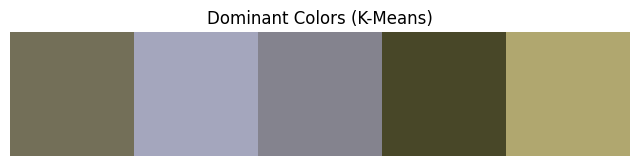

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

img = cv2.imread(monet_paths[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.reshape((-1, 3))

kmeans = KMeans(n_clusters=5)
kmeans.fit(img)
colors = kmeans.cluster_centers_

plt.figure(figsize=(8, 2))
plt.imshow([colors.astype(int)])
plt.axis("off")
plt.title("Dominant Colors (K-Means)")
plt.show()


### **Are There Noise or Distortion in Images?**

Purpose: We can use the Laplace Variance method to analyze the clarity or distortion level of images.

In [9]:
def image_sharpness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    laplacian = cv2.Laplacian(img, cv2.CV_64F).var()
    return laplacian

sharpness_scores = [image_sharpness(img) for img in monet_paths[:300]]
print("Sharpness Scores for images:", sharpness_scores)


Sharpness Scores for images: [3506.829039162956, 1090.6551665959414, 1026.8325680857524, 1271.438694925746, 2603.3721113642678, 1106.3055319152772, 1710.748138466617, 1077.939247008413, 3098.0185387243982, 246.83426783583127, 2281.733706473373, 1282.143867239356, 3577.4113033486065, 205.33121790341102, 162.39376264438033, 500.0188633685466, 2480.4860270989593, 3411.532502235612, 7499.962345599197, 1631.7485042510089, 1623.8910304473247, 2341.3414524493273, 2090.658082692884, 183.62027159985155, 4278.378660558723, 1182.4444091913756, 1135.9235670557246, 2107.4391805788036, 3059.671219214797, 2620.9906222485006, 582.5123721284326, 2268.8283230790403, 1003.7818834176287, 177.1154512257781, 50.69518574117683, 1189.2033650239464, 276.4840569400694, 1024.647226629546, 985.5994848003611, 4506.2445027073845, 1957.9139437042177, 1995.4826763754245, 922.4776458740234, 4076.8543068161234, 1881.5943275382742, 1894.2789120075759, 2069.233861235669, 2330.8694908609614, 3036.447728600353, 4550.688449

### **Similarity Analysis of Monet Images with Deep Learning**

Purpose: To examine the degree of similarity between Monet paintings in terms of style. We can compare Image Features with VGG16.

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

model = VGG16(weights="imagenet", include_top=False, pooling="avg")

def extract_features(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = model.predict(img)
    return features.flatten()

features = [extract_features(img) for img in monet_paths[:5]]

similarities = cosine_similarity(features)
print("Similarity Matrix:")
print(similarities)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Similarity Matrix:
[[1.         0.58629143 0.5163089  0.47112924 0.64852524]
 [0.58629143 1.         0.727273   0.56772107 0.7475793 ]
 [0.5163089  0.727273   0.9999998  0.64968085 0.7810825 ]
 [0.47112924 0.56772107 0.64968085 1.0000002  0.63429105]
 [0.64852524 0.7475793  0.7810825  0.63429105 1.        ]]


### **Pixel Intensity Distribution Analysis in Monet Paintings**

Purpose: To examine the distribution of pixel intensities in Monet paintings and understand the overall brightness levels.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


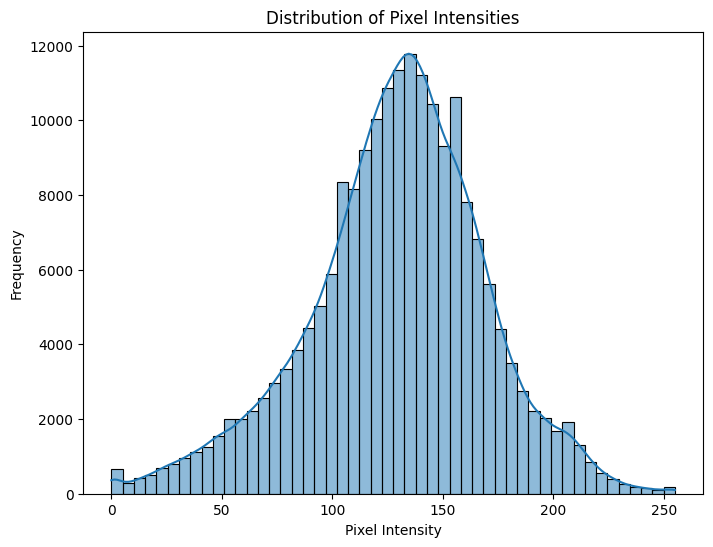

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(img.flatten(), bins=50, kde=True)
plt.title('Distribution of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

Firstly, it was observed that all Monet paintings were 256x256 pixels in size and the dataset was consistent in terms of size. Using Sobel edge detection, it was observed that soft and irregular brush strokes were dominant instead of distinct edge lines in the paintings. In the color distribution analysis, it was determined that green, blue and red tones were used predominantly in Monet's paintings at certain intensities, and the general tone consisted of pastel colors. Monet's 5 most dominant color tones were extracted with the K-Means clustering method and it was confirmed that tones close to nature were dominant. The histogram graph showing the pixel density distribution shows that Monet's works have a medium level of brightness, very few extremely bright or dark tones, and a balanced art style in terms of tone. In addition, the style similarities of the paintings were measured using the VGG16 model and it was determined that there was a 50-80% similarity between Monet's paintings. In addition, in the sharpness analysis of the images (Laplace Variance), it was confirmed that the brush strokes had soft transitions. When comparing based on pixel differences to analyze uniqueness, it was observed that some Monet paintings were quite similar but not exactly the same. These findings show that preserving elements such as color distribution, style characteristics, and pixel density are critical when producing Monet-style images with the GAN model. In the next step, it would be useful to compare the generated images with these analyses and apply preprocessing techniques when necessary to understand how well the model can capture Monet’s art style.

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import time
from PIL import Image

# Defining the Custom InstanceNormalization layer
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # Creating gamma (scale) and beta (shift) parameters for each channel.
        self.gamma = self.add_weight(
            name='gamma',
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True)
        self.beta = self.add_weight(
            name='beta',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True)
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Compute mean and variance for each instance (high dimensions: [batch, height, width])
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self):
        config = super(InstanceNormalization, self).get_config()
        config.update({"epsilon": self.epsilon})
        return config



In [13]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 1        # CycleGAN typically works with batch_size=1.
BUFFER_SIZE = 1000
EPOCHS =    100        # We can increase this based on training duration.
LAMBDA = 5           # Weight for cycle consistency and identity loss.


In [14]:
# Image loading and preprocessing function
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize to the range [-1, 1] for Tanh activation.
    image = (image / 127.5) - 1
    return image

# Adjust file paths according to your environment:
photo_paths = glob.glob("../input/gan-getting-started/photo_jpg/*.jpg")   # Domain X: Path to your photos
monet_paths = glob.glob("../input/gan-getting-started/monet_jpg/*.jpg")   # Domain Y: Path to Monet paintings

# Creating tf.data.Dataset:
dataset_x = tf.data.Dataset.from_tensor_slices(photo_paths)
dataset_x = dataset_x.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset_x = dataset_x.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

dataset_y = tf.data.Dataset.from_tensor_slices(monet_paths)
dataset_y = dataset_y.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset_y = dataset_y.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [15]:
def resnet_block(x, filters, size=3):
    initializer = tf.random_normal_initializer(0., 0.02)
    y = tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                               kernel_initializer=initializer, use_bias=False)(x)
    y = InstanceNormalization()(y)
    y = tf.keras.layers.ReLU()(y)
    y = tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                               kernel_initializer=initializer, use_bias=False)(y)
    y = InstanceNormalization()(y)
    return tf.keras.layers.add([x, y])

def build_generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = tf.keras.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    # First layer
    x = tf.keras.layers.Conv2D(32, 7, strides=1, padding='same',
                               kernel_initializer=initializer, use_bias=False)(inputs)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Downsampling
    x = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # ResNet blocks (4)
    for _ in range(4):
        x = resnet_block(x, 128)
    
    # Upsampling
    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Final layer
    x = tf.keras.layers.Conv2D(3, 7, strides=1, padding='same',
                               kernel_initializer=initializer)(x)
    outputs = tf.keras.layers.Activation('tanh')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = tf.keras.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    x = tf.keras.layers.Conv2D(32, 4, strides=2, padding='same',
                               kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(256, 4, strides=1, padding='same',
                               kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    outputs = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same',
                                     kernel_initializer=initializer)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Model instances for 64x64
generator_g = build_generator()  # Photo -> Monet
generator_f = build_generator()  # Monet -> Photo

discriminator_x = build_discriminator()  # Photos
discriminator_y = build_discriminator()  # Monet

In [16]:
# Loss functions and optimizers

# LSGAN-style loss function
loss_obj = tf.keras.losses.MeanSquaredError()

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return 0.5 * (real_loss + fake_loss)

def calc_cycle_loss(real, cycled):
    loss = tf.reduce_mean(tf.abs(real - cycled))
    return LAMBDA * loss

def identity_loss(real, same):
    loss = tf.reduce_mean(tf.abs(real - same))
    return 0.5 * LAMBDA * loss

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [17]:
# Defining the training step function
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Photo to Monet: X -> Y
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        # Monet to Photo: Y -> X
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # Identity mapping: Keeping the real input unchanged
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # Generator adversarial losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        # Cycle consistency loss
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Identity loss
        id_loss_g = identity_loss(real_y, same_y)
        id_loss_f = identity_loss(real_x, same_x)
        
        total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss_g
        total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss_f
        
        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Compute gradients
    gradients_g = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    gradients_f = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    gradients_disc_x = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    gradients_disc_y = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Update weights
    generator_g_optimizer.apply_gradients(zip(gradients_g, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(gradients_f, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(gradients_disc_x, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(gradients_disc_y, discriminator_y.trainable_variables))
    
    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss


Epoch 1, Batch 100: Gen G Loss = 5.3224, Gen F Loss = 5.2123
Epoch 1, Batch 200: Gen G Loss = 2.9427, Gen F Loss = 3.4373
Epoch 1, Batch 300: Gen G Loss = 3.7500, Gen F Loss = 3.9212
Epoch 1 duration: 46.61 sec
Epoch 2, Batch 100: Gen G Loss = 4.6760, Gen F Loss = 4.4729
Epoch 2, Batch 200: Gen G Loss = 3.2637, Gen F Loss = 3.7476
Epoch 2, Batch 300: Gen G Loss = 3.0498, Gen F Loss = 3.4063
Epoch 2 duration: 15.61 sec
Epoch 3, Batch 100: Gen G Loss = 3.9445, Gen F Loss = 4.1269
Epoch 3, Batch 200: Gen G Loss = 3.8074, Gen F Loss = 3.3379
Epoch 3, Batch 300: Gen G Loss = 4.1647, Gen F Loss = 4.5179
Epoch 3 duration: 15.23 sec
Epoch 4, Batch 100: Gen G Loss = 3.0063, Gen F Loss = 3.0592
Epoch 4, Batch 200: Gen G Loss = 3.1048, Gen F Loss = 2.7870
Epoch 4, Batch 300: Gen G Loss = 3.1933, Gen F Loss = 3.1697
Epoch 4 duration: 15.35 sec
Epoch 5, Batch 100: Gen G Loss = 3.1381, Gen F Loss = 3.0630
Epoch 5, Batch 200: Gen G Loss = 3.5018, Gen F Loss = 3.5451
Epoch 5, Batch 300: Gen G Loss = 2

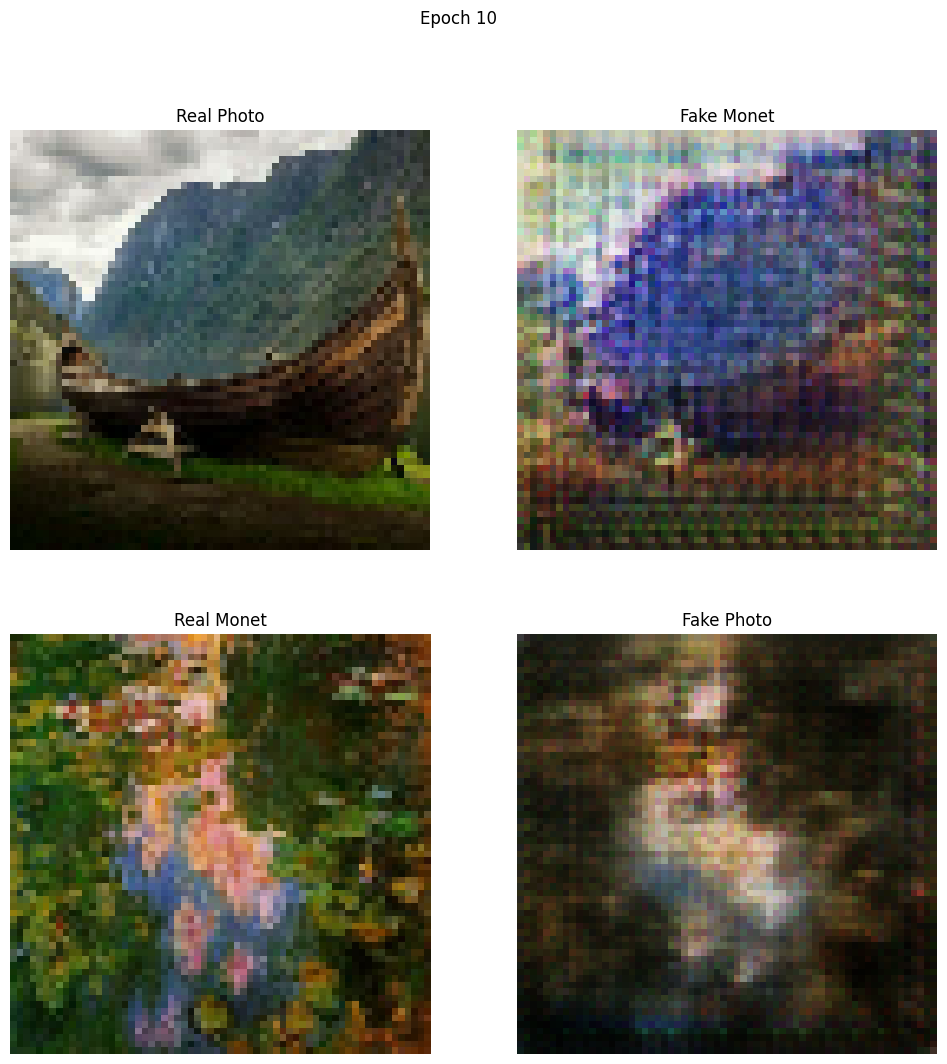

Epoch 11, Batch 100: Gen G Loss = 3.6509, Gen F Loss = 3.2537
Epoch 11, Batch 200: Gen G Loss = 2.4352, Gen F Loss = 2.6688
Epoch 11, Batch 300: Gen G Loss = 2.6334, Gen F Loss = 2.2853
Epoch 11 duration: 15.28 sec
Epoch 12, Batch 100: Gen G Loss = 2.5188, Gen F Loss = 2.4561
Epoch 12, Batch 200: Gen G Loss = 3.1949, Gen F Loss = 3.0729
Epoch 12, Batch 300: Gen G Loss = 2.9817, Gen F Loss = 2.9135
Epoch 12 duration: 15.29 sec
Epoch 13, Batch 100: Gen G Loss = 2.7121, Gen F Loss = 2.6794
Epoch 13, Batch 200: Gen G Loss = 3.3479, Gen F Loss = 3.2151
Epoch 13, Batch 300: Gen G Loss = 3.6636, Gen F Loss = 3.3827
Epoch 13 duration: 15.15 sec
Epoch 14, Batch 100: Gen G Loss = 2.4279, Gen F Loss = 2.5802
Epoch 14, Batch 200: Gen G Loss = 3.4936, Gen F Loss = 3.2984
Epoch 14, Batch 300: Gen G Loss = 2.5157, Gen F Loss = 2.4003
Epoch 14 duration: 15.33 sec
Epoch 15, Batch 100: Gen G Loss = 2.7058, Gen F Loss = 2.8071
Epoch 15, Batch 200: Gen G Loss = 2.3136, Gen F Loss = 2.5064
Epoch 15, Batch 

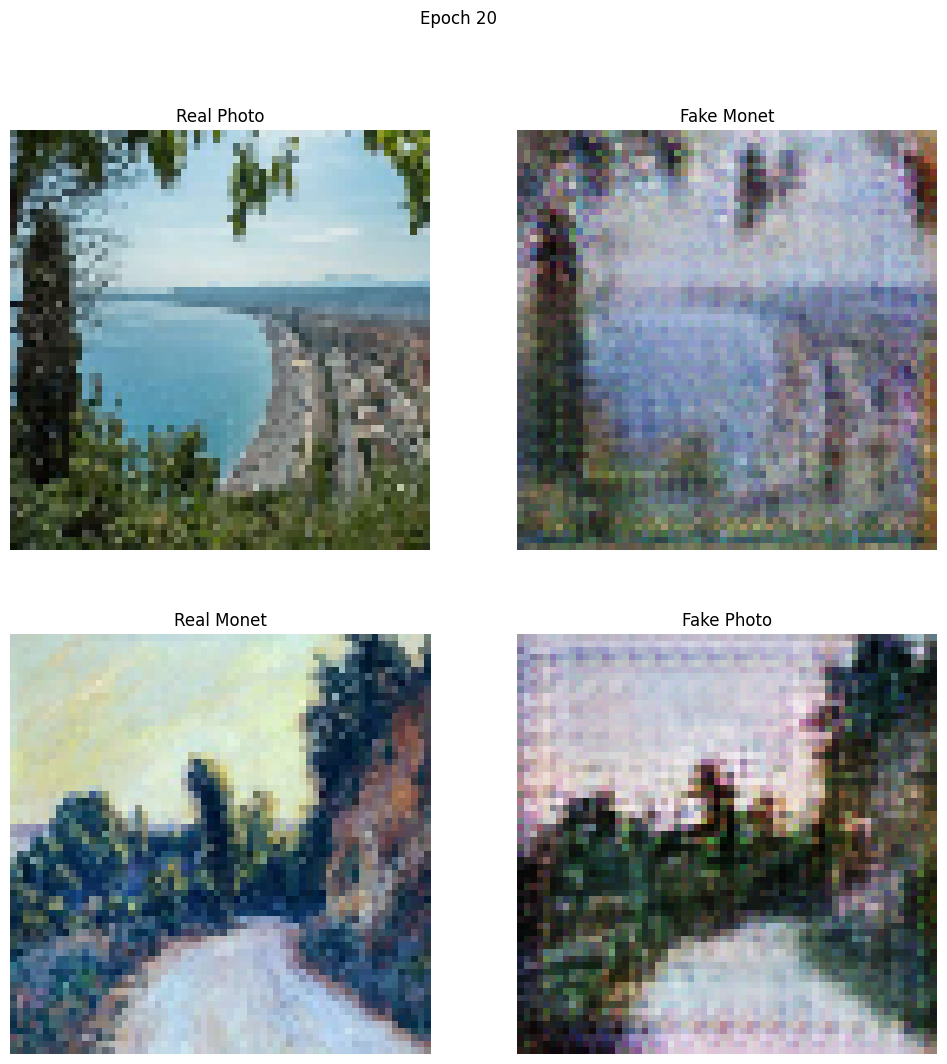

Epoch 21, Batch 100: Gen G Loss = 3.4359, Gen F Loss = 3.0492
Epoch 21, Batch 200: Gen G Loss = 2.6240, Gen F Loss = 3.1638
Epoch 21, Batch 300: Gen G Loss = 3.1616, Gen F Loss = 3.4230
Epoch 21 duration: 15.32 sec
Epoch 22, Batch 100: Gen G Loss = 3.5497, Gen F Loss = 2.9151
Epoch 22, Batch 200: Gen G Loss = 2.9095, Gen F Loss = 3.2980
Epoch 22, Batch 300: Gen G Loss = 2.2671, Gen F Loss = 1.8814
Epoch 22 duration: 15.36 sec
Epoch 23, Batch 100: Gen G Loss = 3.5598, Gen F Loss = 3.2977
Epoch 23, Batch 200: Gen G Loss = 2.8374, Gen F Loss = 2.6719
Epoch 23, Batch 300: Gen G Loss = 2.9880, Gen F Loss = 2.9805
Epoch 23 duration: 15.45 sec
Epoch 24, Batch 100: Gen G Loss = 3.1814, Gen F Loss = 2.5555
Epoch 24, Batch 200: Gen G Loss = 2.5286, Gen F Loss = 2.1006
Epoch 24, Batch 300: Gen G Loss = 3.8392, Gen F Loss = 3.1534
Epoch 24 duration: 15.14 sec
Epoch 25, Batch 100: Gen G Loss = 2.2201, Gen F Loss = 2.2582
Epoch 25, Batch 200: Gen G Loss = 2.0937, Gen F Loss = 1.9913
Epoch 25, Batch 

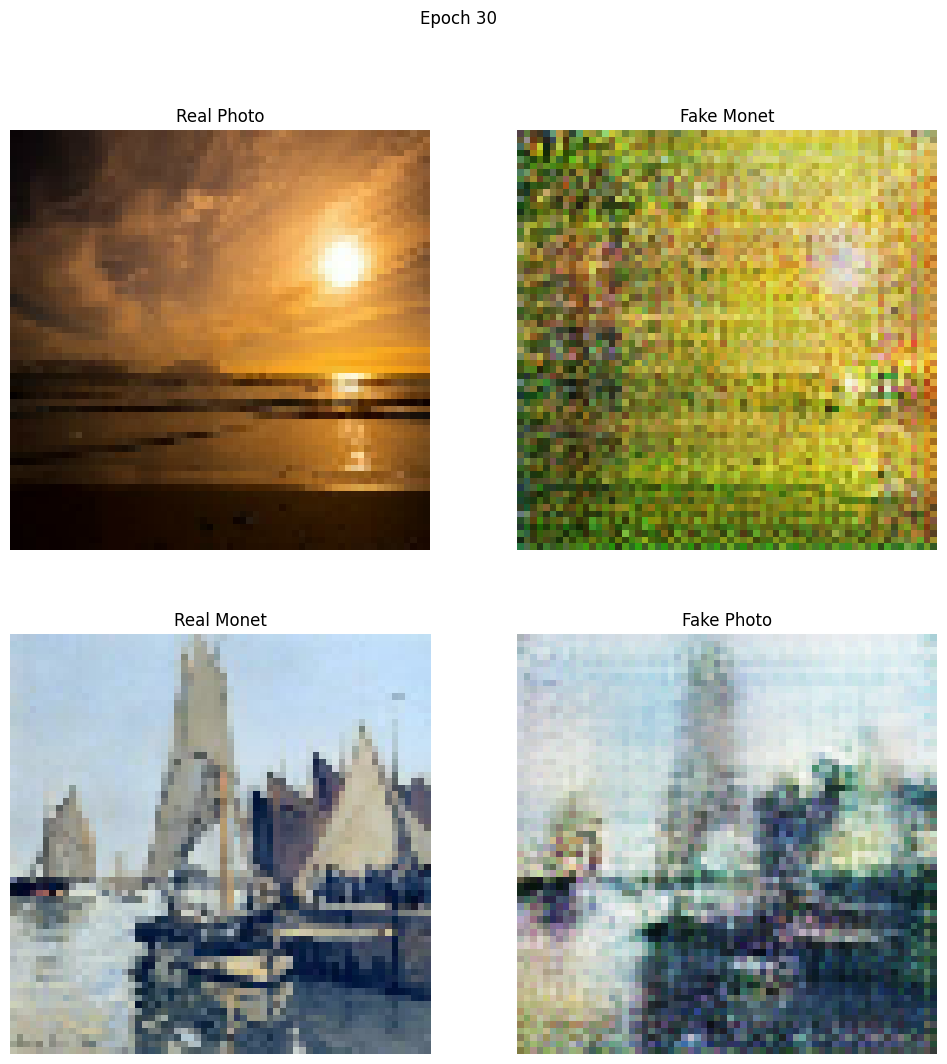

Epoch 31, Batch 100: Gen G Loss = 2.6710, Gen F Loss = 1.7558
Epoch 31, Batch 200: Gen G Loss = 2.7602, Gen F Loss = 2.7240
Epoch 31, Batch 300: Gen G Loss = 2.8376, Gen F Loss = 2.0163
Epoch 31 duration: 16.79 sec
Epoch 32, Batch 100: Gen G Loss = 3.6835, Gen F Loss = 2.7150
Epoch 32, Batch 200: Gen G Loss = 2.3200, Gen F Loss = 2.6652
Epoch 32, Batch 300: Gen G Loss = 3.0917, Gen F Loss = 3.4172
Epoch 32 duration: 15.24 sec
Epoch 33, Batch 100: Gen G Loss = 2.8378, Gen F Loss = 2.5590
Epoch 33, Batch 200: Gen G Loss = 2.9887, Gen F Loss = 2.0540
Epoch 33, Batch 300: Gen G Loss = 2.8466, Gen F Loss = 3.0986
Epoch 33 duration: 15.46 sec
Epoch 34, Batch 100: Gen G Loss = 3.0652, Gen F Loss = 2.6083
Epoch 34, Batch 200: Gen G Loss = 2.6582, Gen F Loss = 2.2114
Epoch 34, Batch 300: Gen G Loss = 3.2251, Gen F Loss = 2.7238
Epoch 34 duration: 15.24 sec
Epoch 35, Batch 100: Gen G Loss = 2.3790, Gen F Loss = 2.1720
Epoch 35, Batch 200: Gen G Loss = 2.0731, Gen F Loss = 2.3252
Epoch 35, Batch 

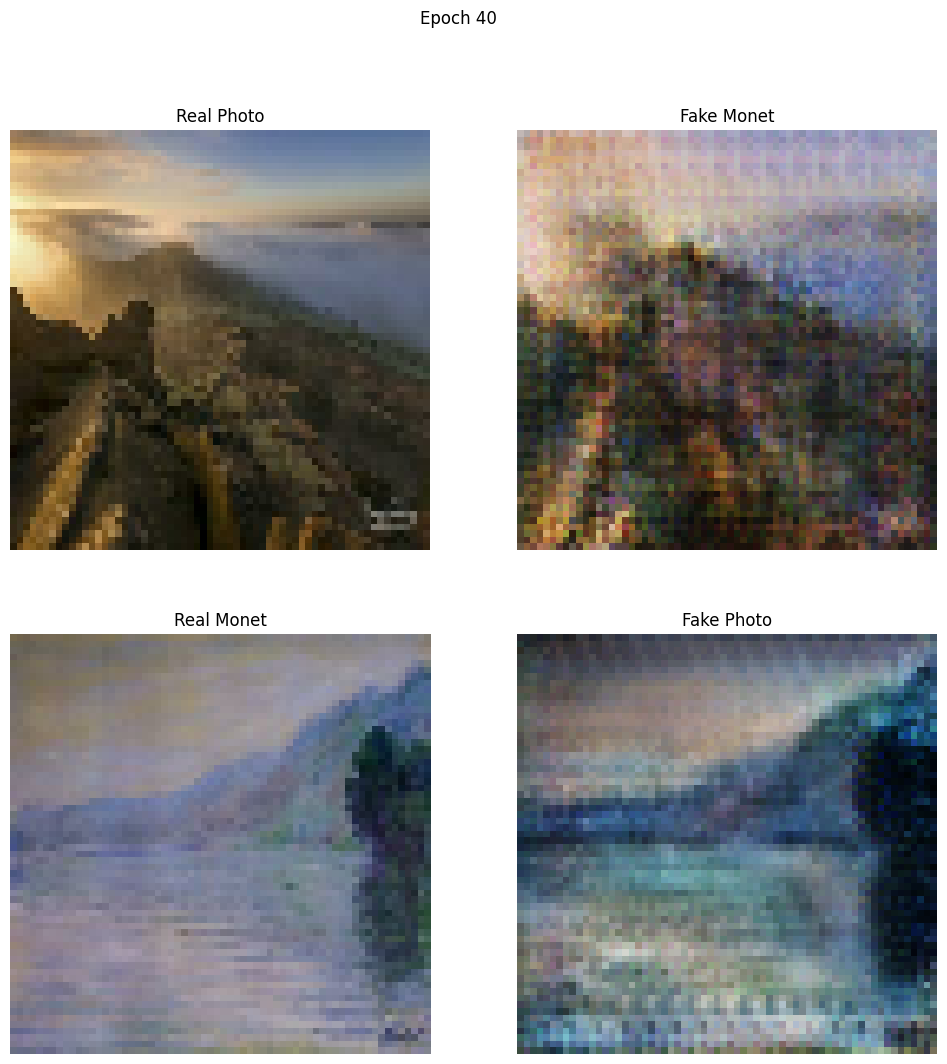

Epoch 41, Batch 100: Gen G Loss = 3.2093, Gen F Loss = 2.8801
Epoch 41, Batch 200: Gen G Loss = 3.6139, Gen F Loss = 3.7368
Epoch 41, Batch 300: Gen G Loss = 1.9488, Gen F Loss = 2.1158
Epoch 41 duration: 15.32 sec
Epoch 42, Batch 100: Gen G Loss = 3.3357, Gen F Loss = 2.8020
Epoch 42, Batch 200: Gen G Loss = 2.8089, Gen F Loss = 2.5808
Epoch 42, Batch 300: Gen G Loss = 2.5734, Gen F Loss = 2.0963
Epoch 42 duration: 15.16 sec
Epoch 43, Batch 100: Gen G Loss = 2.5466, Gen F Loss = 2.4358
Epoch 43, Batch 200: Gen G Loss = 3.0522, Gen F Loss = 2.7340
Epoch 43, Batch 300: Gen G Loss = 3.2583, Gen F Loss = 2.1896
Epoch 43 duration: 15.30 sec
Epoch 44, Batch 100: Gen G Loss = 2.9543, Gen F Loss = 2.6725
Epoch 44, Batch 200: Gen G Loss = 3.3200, Gen F Loss = 3.0067
Epoch 44, Batch 300: Gen G Loss = 3.8037, Gen F Loss = 3.3963
Epoch 44 duration: 15.45 sec
Epoch 45, Batch 100: Gen G Loss = 2.4789, Gen F Loss = 2.3183
Epoch 45, Batch 200: Gen G Loss = 2.8894, Gen F Loss = 2.9967
Epoch 45, Batch 

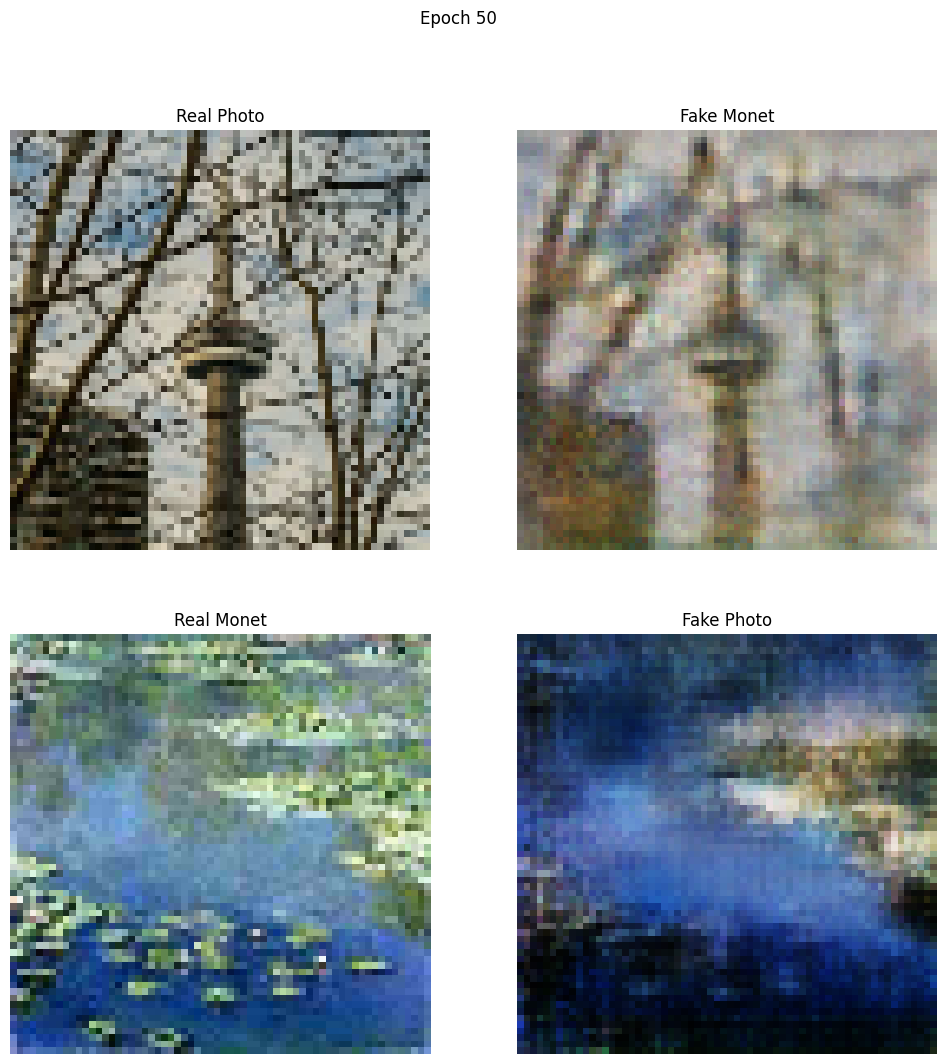

Epoch 51, Batch 100: Gen G Loss = 2.6651, Gen F Loss = 2.2740
Epoch 51, Batch 200: Gen G Loss = 2.4030, Gen F Loss = 2.0043
Epoch 51, Batch 300: Gen G Loss = 2.4323, Gen F Loss = 2.2886
Epoch 51 duration: 15.16 sec
Epoch 52, Batch 100: Gen G Loss = 2.3733, Gen F Loss = 2.1843
Epoch 52, Batch 200: Gen G Loss = 2.9868, Gen F Loss = 2.6910
Epoch 52, Batch 300: Gen G Loss = 2.9422, Gen F Loss = 2.1504
Epoch 52 duration: 15.41 sec
Epoch 53, Batch 100: Gen G Loss = 2.8974, Gen F Loss = 3.2431
Epoch 53, Batch 200: Gen G Loss = 2.0395, Gen F Loss = 1.6447
Epoch 53, Batch 300: Gen G Loss = 3.9071, Gen F Loss = 3.8451
Epoch 53 duration: 15.53 sec
Epoch 54, Batch 100: Gen G Loss = 2.6702, Gen F Loss = 2.5436
Epoch 54, Batch 200: Gen G Loss = 3.3891, Gen F Loss = 3.2929
Epoch 54, Batch 300: Gen G Loss = 3.1018, Gen F Loss = 2.0461
Epoch 54 duration: 15.30 sec
Epoch 55, Batch 100: Gen G Loss = 2.7267, Gen F Loss = 2.2915
Epoch 55, Batch 200: Gen G Loss = 2.7130, Gen F Loss = 2.3714
Epoch 55, Batch 

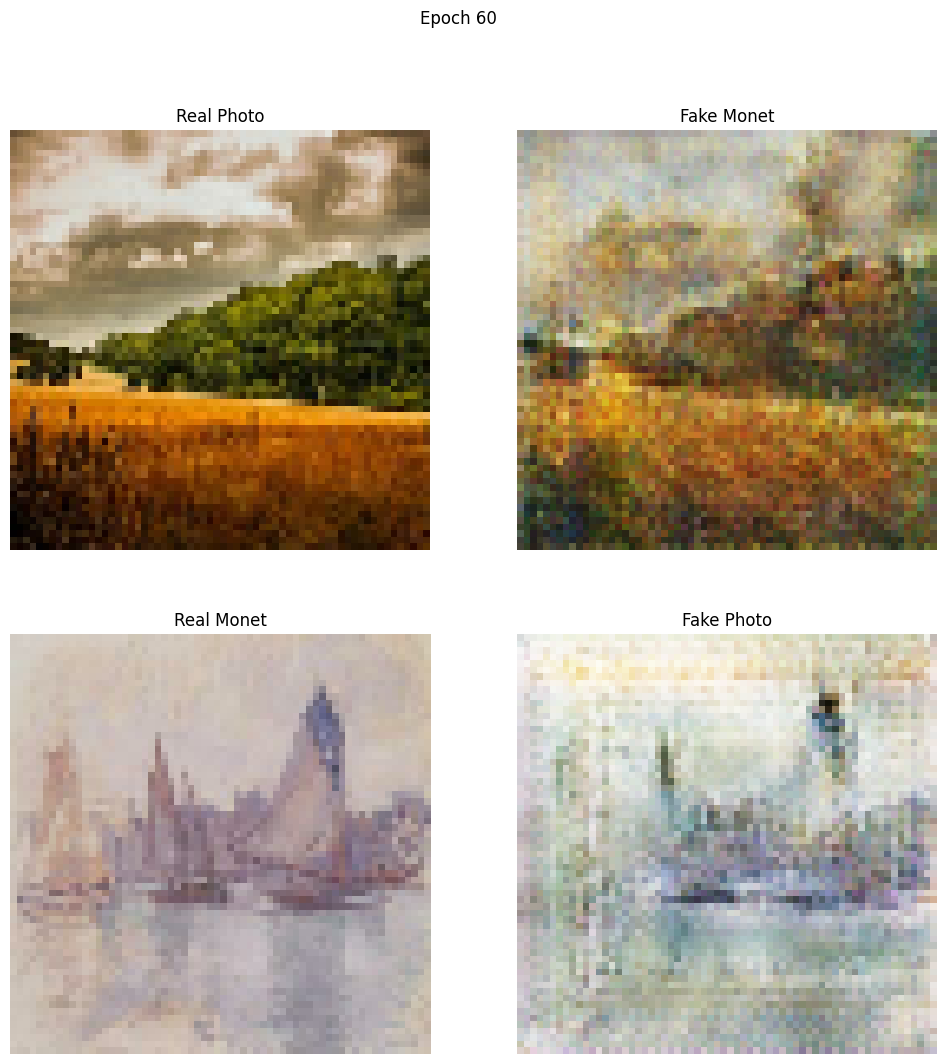

Epoch 61, Batch 100: Gen G Loss = 3.3566, Gen F Loss = 2.7720
Epoch 61, Batch 200: Gen G Loss = 3.1591, Gen F Loss = 2.2481
Epoch 61, Batch 300: Gen G Loss = 2.8689, Gen F Loss = 2.5633
Epoch 61 duration: 15.38 sec
Epoch 62, Batch 100: Gen G Loss = 2.4257, Gen F Loss = 2.3820
Epoch 62, Batch 200: Gen G Loss = 3.1472, Gen F Loss = 2.3275
Epoch 62, Batch 300: Gen G Loss = 2.9072, Gen F Loss = 2.4129
Epoch 62 duration: 15.28 sec
Epoch 63, Batch 100: Gen G Loss = 2.4153, Gen F Loss = 1.9293
Epoch 63, Batch 200: Gen G Loss = 2.6526, Gen F Loss = 2.4348
Epoch 63, Batch 300: Gen G Loss = 2.5278, Gen F Loss = 2.3738
Epoch 63 duration: 15.28 sec
Epoch 64, Batch 100: Gen G Loss = 2.3917, Gen F Loss = 2.0816
Epoch 64, Batch 200: Gen G Loss = 2.8425, Gen F Loss = 2.2489
Epoch 64, Batch 300: Gen G Loss = 2.8425, Gen F Loss = 2.0078
Epoch 64 duration: 15.31 sec
Epoch 65, Batch 100: Gen G Loss = 2.9005, Gen F Loss = 2.5100
Epoch 65, Batch 200: Gen G Loss = 2.9386, Gen F Loss = 2.5043
Epoch 65, Batch 

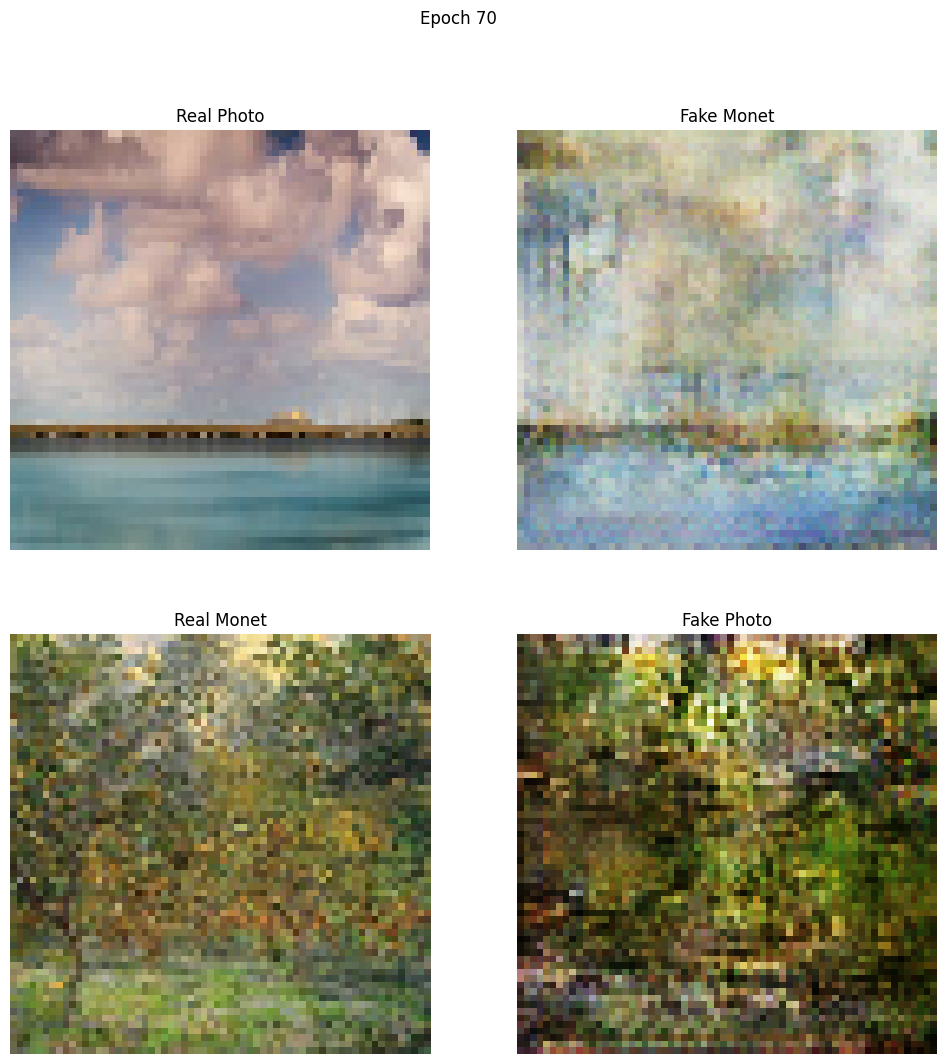

Epoch 71, Batch 100: Gen G Loss = 2.9701, Gen F Loss = 2.5411
Epoch 71, Batch 200: Gen G Loss = 3.4987, Gen F Loss = 3.1156
Epoch 71, Batch 300: Gen G Loss = 3.3076, Gen F Loss = 2.1756
Epoch 71 duration: 15.25 sec
Epoch 72, Batch 100: Gen G Loss = 2.7141, Gen F Loss = 2.4624
Epoch 72, Batch 200: Gen G Loss = 3.1238, Gen F Loss = 2.1581
Epoch 72, Batch 300: Gen G Loss = 2.7243, Gen F Loss = 2.6893
Epoch 72 duration: 15.54 sec
Epoch 73, Batch 100: Gen G Loss = 1.9320, Gen F Loss = 1.7530
Epoch 73, Batch 200: Gen G Loss = 2.8014, Gen F Loss = 2.9656
Epoch 73, Batch 300: Gen G Loss = 2.7825, Gen F Loss = 2.2483
Epoch 73 duration: 15.14 sec
Epoch 74, Batch 100: Gen G Loss = 2.9110, Gen F Loss = 2.3928
Epoch 74, Batch 200: Gen G Loss = 3.1166, Gen F Loss = 2.4874
Epoch 74, Batch 300: Gen G Loss = 2.8594, Gen F Loss = 2.3450
Epoch 74 duration: 15.20 sec
Epoch 75, Batch 100: Gen G Loss = 2.4973, Gen F Loss = 2.7392
Epoch 75, Batch 200: Gen G Loss = 2.4863, Gen F Loss = 2.1939
Epoch 75, Batch 

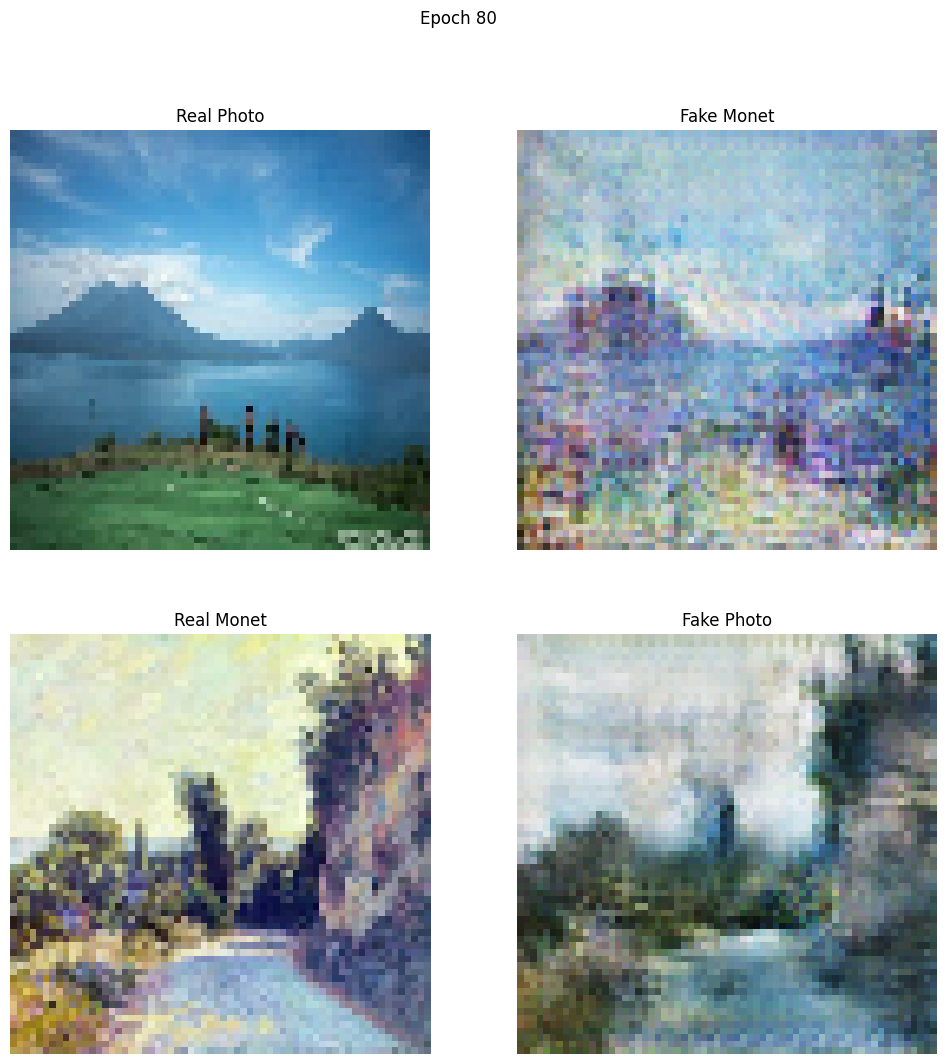

Epoch 81, Batch 100: Gen G Loss = 2.6672, Gen F Loss = 2.1189
Epoch 81, Batch 200: Gen G Loss = 3.1949, Gen F Loss = 2.8776
Epoch 81, Batch 300: Gen G Loss = 2.5160, Gen F Loss = 2.1729
Epoch 81 duration: 15.21 sec
Epoch 82, Batch 100: Gen G Loss = 2.9575, Gen F Loss = 2.3759
Epoch 82, Batch 200: Gen G Loss = 3.2030, Gen F Loss = 2.9976
Epoch 82, Batch 300: Gen G Loss = 3.0522, Gen F Loss = 2.4599
Epoch 82 duration: 15.33 sec
Epoch 83, Batch 100: Gen G Loss = 2.7133, Gen F Loss = 2.4603
Epoch 83, Batch 200: Gen G Loss = 2.8270, Gen F Loss = 2.2326
Epoch 83, Batch 300: Gen G Loss = 3.7618, Gen F Loss = 2.8249
Epoch 83 duration: 15.24 sec
Epoch 84, Batch 100: Gen G Loss = 3.0609, Gen F Loss = 2.8791
Epoch 84, Batch 200: Gen G Loss = 3.2312, Gen F Loss = 2.2450
Epoch 84, Batch 300: Gen G Loss = 2.5258, Gen F Loss = 2.3301
Epoch 84 duration: 15.42 sec
Epoch 85, Batch 100: Gen G Loss = 2.9779, Gen F Loss = 2.1697
Epoch 85, Batch 200: Gen G Loss = 3.1936, Gen F Loss = 2.5655
Epoch 85, Batch 

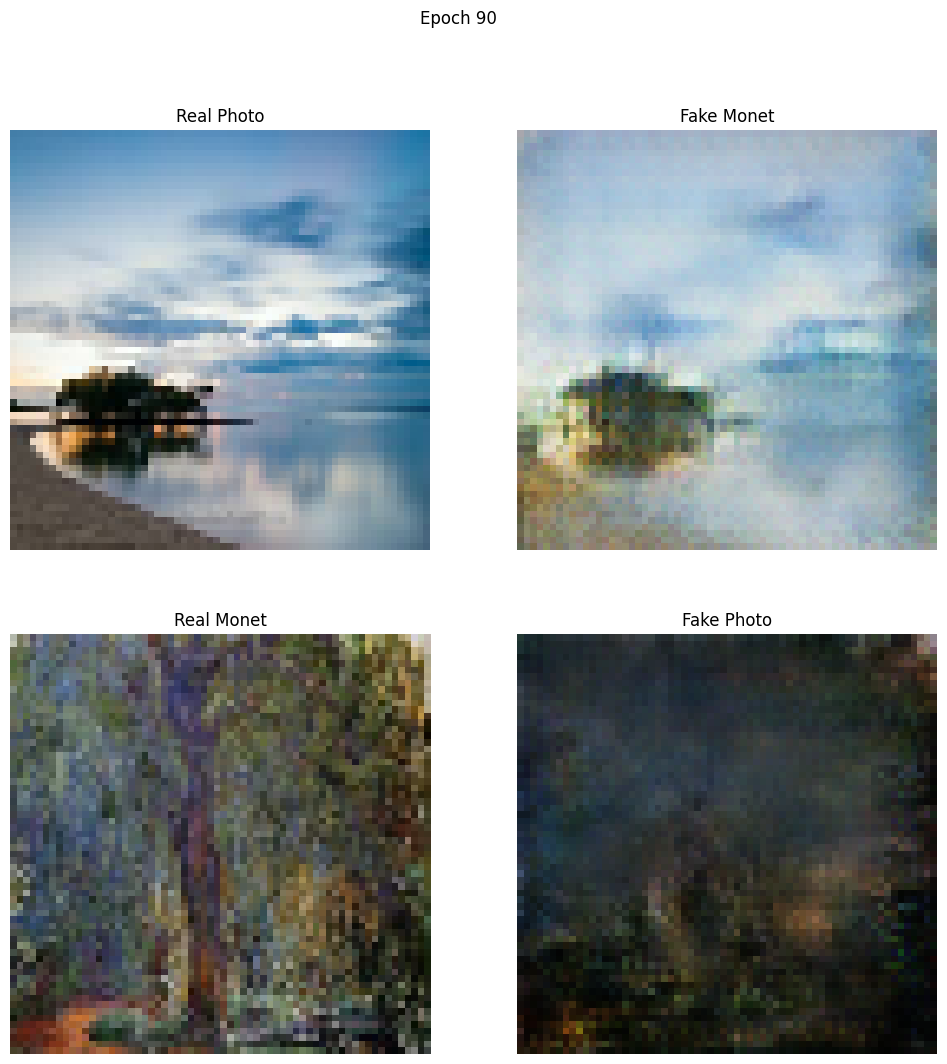

Epoch 91, Batch 100: Gen G Loss = 3.1293, Gen F Loss = 2.3001
Epoch 91, Batch 200: Gen G Loss = 3.2087, Gen F Loss = 2.4394
Epoch 91, Batch 300: Gen G Loss = 2.9268, Gen F Loss = 2.5998
Epoch 91 duration: 15.38 sec
Epoch 92, Batch 100: Gen G Loss = 2.5874, Gen F Loss = 2.2511
Epoch 92, Batch 200: Gen G Loss = 2.2439, Gen F Loss = 2.0383
Epoch 92, Batch 300: Gen G Loss = 3.6229, Gen F Loss = 3.0508
Epoch 92 duration: 15.35 sec
Epoch 93, Batch 100: Gen G Loss = 2.5411, Gen F Loss = 2.4729
Epoch 93, Batch 200: Gen G Loss = 2.5762, Gen F Loss = 2.2200
Epoch 93, Batch 300: Gen G Loss = 2.9473, Gen F Loss = 2.6873
Epoch 93 duration: 15.24 sec
Epoch 94, Batch 100: Gen G Loss = 2.3906, Gen F Loss = 1.8801
Epoch 94, Batch 200: Gen G Loss = 2.9406, Gen F Loss = 2.6734
Epoch 94, Batch 300: Gen G Loss = 3.0125, Gen F Loss = 2.7548
Epoch 94 duration: 15.22 sec
Epoch 95, Batch 100: Gen G Loss = 3.1782, Gen F Loss = 2.6615
Epoch 95, Batch 200: Gen G Loss = 2.5381, Gen F Loss = 2.4133
Epoch 95, Batch 

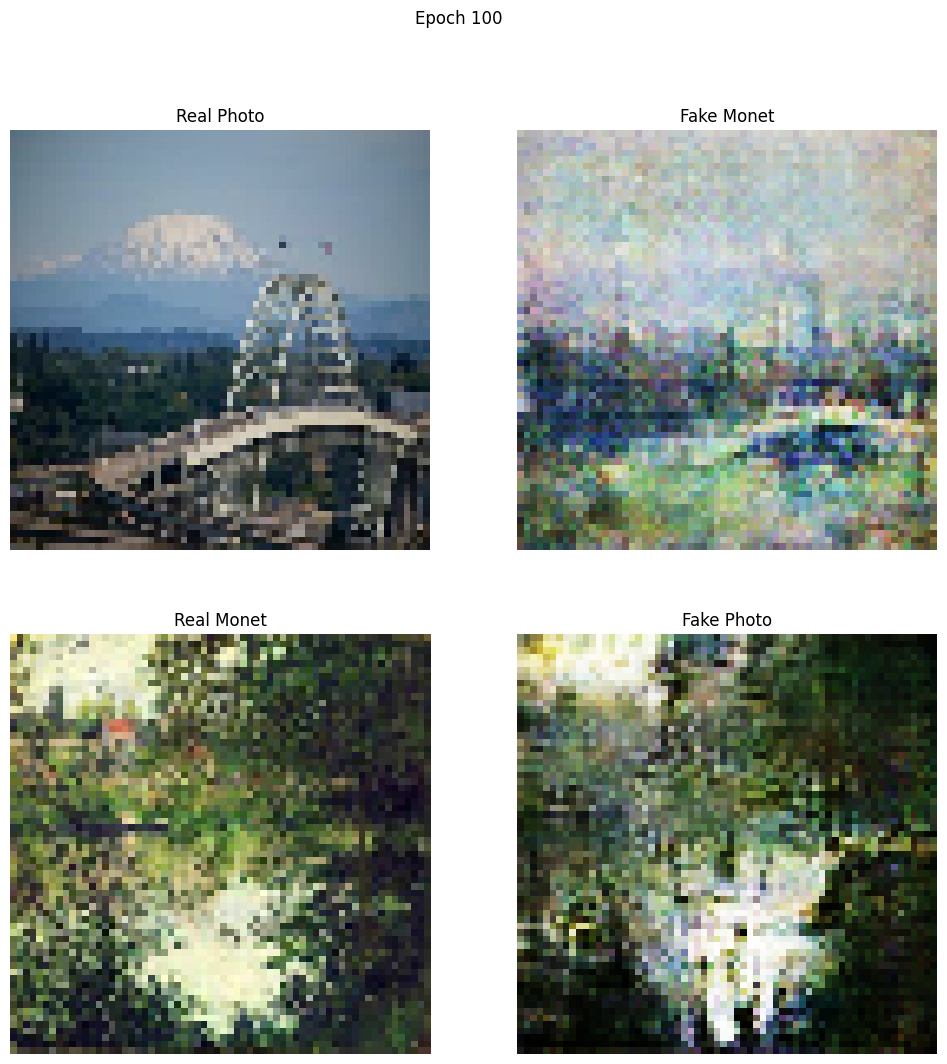

In [18]:
# Training loop and generating sample images during training

def generate_sample_images(real_x, real_y, epoch):
    # Generate transformations: Real photo to Monet & Real Monet to photo
    fake_y = generator_g(real_x, training=False)
    fake_x = generator_f(real_y, training=False)
    
    plt.figure(figsize=(12, 12))
    images = [real_x[0], fake_y[0], real_y[0], fake_x[0]]
    titles = ['Real Photo', 'Fake Monet', 'Real Monet', 'Fake Photo']
    
    for i in range(4):
        plt.subplot(2, 2, i+1)
        # Scale images from [-1,1] to [0,1]
        img = (images[i] + 1) / 2.0
        plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

for epoch in range(1, EPOCHS + 1):
    start = time.time()
    n = 0
    # Zip both datasets to fetch batches from both domains
    for real_x, real_y in tf.data.Dataset.zip((dataset_x, dataset_y)):
        total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(real_x, real_y)
        n += 1
        if n % 100 == 0:
            print(f"Epoch {epoch}, Batch {n}: Gen G Loss = {total_gen_g_loss:.4f}, Gen F Loss = {total_gen_f_loss:.4f}")
    print(f"Epoch {epoch} duration: {time.time() - start:.2f} sec")
    
    # Generate and display sample images at the end of each 10 epoch
    if epoch % 10 == 0:
        sample_x = next(iter(dataset_x))
        sample_y = next(iter(dataset_y))
        generate_sample_images(sample_x, sample_y, epoch)

In [19]:
import os
import shutil
import tensorflow as tf
from PIL import Image

# Define output folder (in Kaggle working directory)
output_folder = "/kaggle/working/images"
os.makedirs(output_folder, exist_ok=True)

# Set the number of images to generate (e.g., 7000)
num_images_to_generate = 7000
counter = 0

# Iterate over dataset_x and generate Monet-style images for each photo
for photo_batch in dataset_x:  # dataset_x: tf.data.Dataset containing photos (batch_size=1)
    # Use generator_g to generate fake Monet images from photo batch
    fake_monet = generator_g(photo_batch, training=False)
    
    # Each batch (batch_size=1) may contain one or more images
    for i in range(fake_monet.shape[0]):
        # Convert images from [-1,1] range to [0,1] range
        img = (fake_monet[i] + 1.0) / 2.0
        # Convert image to uint8 type (0-255 range)
        img = tf.image.convert_image_dtype(img, tf.uint8)
        img_array = img.numpy()
        # Save the image to the specified folder
        save_path = os.path.join(output_folder, f"monet_{counter}.jpg")
        Image.fromarray(img_array).save(save_path)
        counter += 1
        if counter >= num_images_to_generate:
            break
    if counter >= num_images_to_generate:
        break

print(f"{counter} Monet-style images saved to '{output_folder}'.")

# Convert folder to a zip file
zip_path = output_folder  # Name and path of the zip file
shutil.make_archive(zip_path, 'zip', output_folder)
print(f"{zip_path}.zip created!")

# Optional: List the first 10 files in the folder
print("First 10 files:")
!ls "{output_folder}" | head -n 10


7000 Monet-style images saved to '/kaggle/working/images'.
/kaggle/working/images.zip created!
First 10 files:
monet_0.jpg
monet_1000.jpg
monet_1001.jpg
monet_1002.jpg
monet_1003.jpg
monet_1004.jpg
monet_1005.jpg
monet_1006.jpg
monet_1007.jpg
monet_1008.jpg
ls: write error: Broken pipe
